<a href="https://colab.research.google.com/github/SauloHenriqueAguiar/LSTMSerieTemporalESP32/blob/main/SerieTemporalTemperaturaUnivariavelLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SérieTemporal de Temperatura(univariável) para microcontrolador ESP32





In [32]:
# Importing bibliotecas
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [33]:
### dados do Max plank Instituto de pesquisa 

zip_path = tf.keras.utils.get_file(origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip' , fname='jena_climate_2009_2016.csv.zip', extract=True)
print(zip_path)

csv_path = os.path.splitext(zip_path)

print(csv_path)

/root/.keras/datasets/jena_climate_2009_2016.csv.zip
('/root/.keras/datasets/jena_climate_2009_2016.csv', '.zip')


In [34]:
! ls /root/.keras/datasets/

jena_climate_2009_2016.csv  jena_climate_2009_2016.csv.zip


In [35]:
### criando dataset csv
import zipfile

zf = zipfile.ZipFile(zip_path)
df = pd.read_csv(zf.open('jena_climate_2009_2016.csv'))

df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [36]:
##  usando somente a temperatura(univariavel)

uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

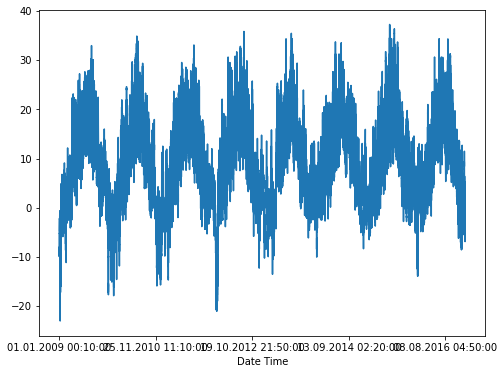

In [37]:
uni_data.plot()

In [38]:
uni_data = uni_data.values

In [39]:
## divisão de teste  para média de janela móvel de série temporal simples
train_split = 300000
tf.random.set_seed(13)

In [40]:
### padronizar dados
uni_data_mean = uni_data[:train_split].mean()
uni_data_std = uni_data[:train_split].std()
uni_data  = (uni_data - uni_data_mean)/ uni_data_std

print(type(uni_data))

<class 'numpy.ndarray'>


In [41]:
## funções de utilidade

## função para criar dados para previsão univariada

def univariate_data(dataset, start_idx , end_idx , history_size, target_size):
  data = []
  labels = []
  start_idx  = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx):
    idxs = range(i-history_size , i)
    data.append(np.reshape(dataset[idxs] , (history_size, 1))) ### remodelar dados
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

uni_data_history = 20   ## últimos 20 valores
uni_data_future = 0     ## dados futuros

x_train_uni , y_train_uni = univariate_data(uni_data , 0 , train_split , uni_data_history , uni_data_future)

x_val_uni , y_val_uni = univariate_data(uni_data , train_split , None ,uni_data_history , uni_data_future)

In [42]:
print(x_train_uni.shape , y_train_uni.shape)
print(x_val_uni.shape , y_val_uni.shape)

(299980, 20, 1) (299980,)
(120531, 20, 1) (120531,)


In [43]:
print('Janela única de dados do histórico' , x_train_uni[0])

print('Temperatura alvo a prever ' , y_train_uni[0])

Janela única de dados do histórico [[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]
Temperatura alvo a prever  -2.1041848598100876


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

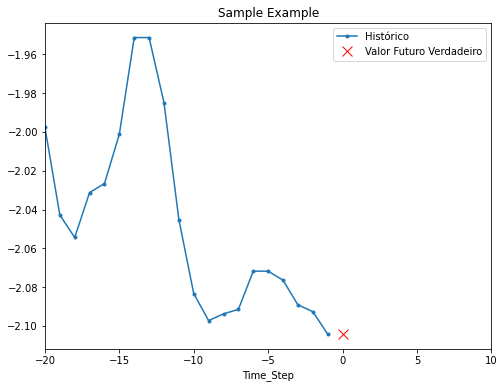

In [44]:
### função para criar passos de tempo
def create_time_steps(length):
  return list(range(-length,0))

### função para plotar dados de séries temporais

def plot_time_series(plot_data, delta , title):
  labels = ["Histórico" , 'Valor Futuro Verdadeiro' , 'Valor Predito Pelo Modelo']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt

plot_time_series([x_train_uni[0] , y_train_uni[0]] , 0 , 'Sample Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

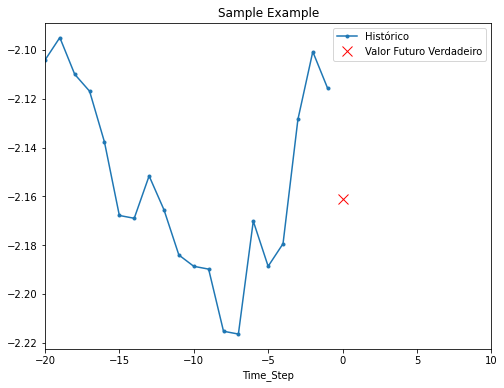

In [45]:
i = 20
plot_time_series([x_train_uni[i], y_train_uni[i]] , 0 , 'Sample Example')

In [46]:
### Média da janela móvel

def MWA(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

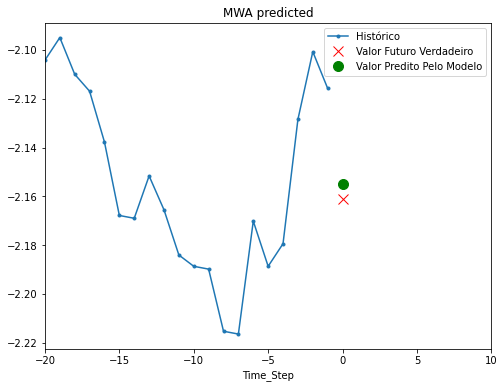

In [47]:
i = 20
plot_time_series([x_train_uni[i] , y_train_uni[i] , MWA(x_train_uni[i])] , 0 , 'MWA predicted')

In [48]:
## preparar o conjunto de dados do tensorflow
batch_size = 256
buffer_size = 10000

train_uni = tf.data.Dataset.from_tensor_slices((x_train_uni , y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_uni = tf.data.Dataset.from_tensor_slices((x_val_uni , y_val_uni))
val_uni = val_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_uni)
print(val_uni)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [49]:
## Definir o modelo LSTM  

lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(16 , input_shape = x_train_uni.shape[-2:]), 
                                         tf.keras.layers.Dense(1)])

lstm_model.compile(optimizer = 'adam', loss = 'mae')

steps = 200

EPOCHS =10

lstm_model.fit(train_uni , epochs = EPOCHS, steps_per_epoch = steps ,
               validation_data = val_uni, validation_steps = 50)

Epoch 1/10
200/200 [==============================] - 4s 11ms/step - loss: 0.1597 - val_loss: 0.0306
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0397 - val_loss: 0.0247
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0324 - val_loss: 0.0226
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0290 - val_loss: 0.0199
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0223 - val_loss: 0.0180
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0242 - val_loss: 0.0173
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0222 - val_loss: 0.0166
Epoch 8/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0209 - val_loss: 0.0176
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0205 - val_loss: 0.0148
Epoch 10/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0188 - val_loss: 0.013

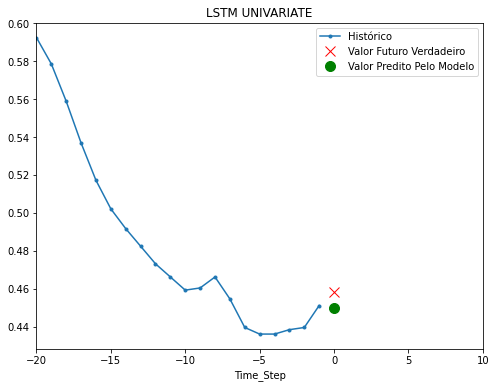

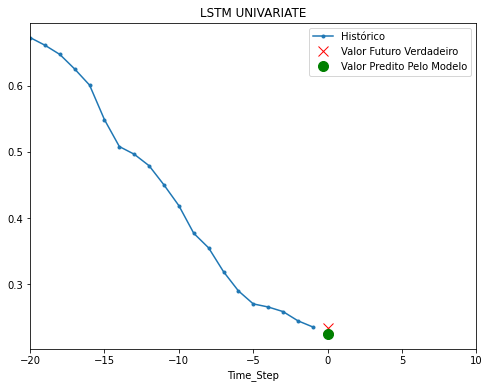

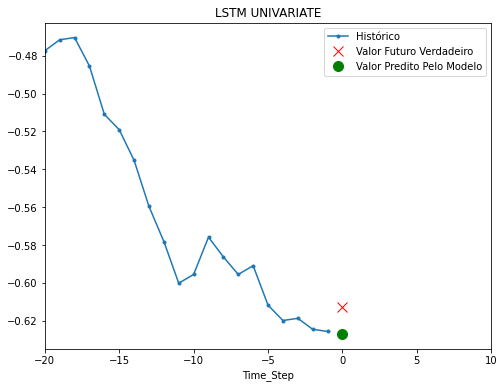

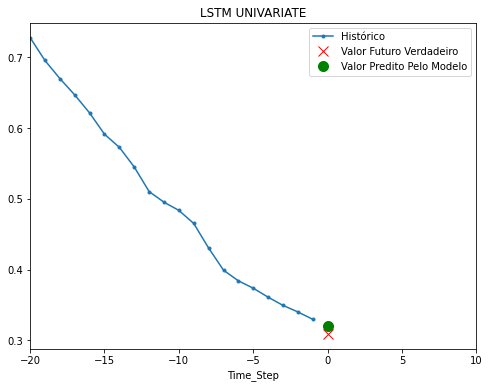

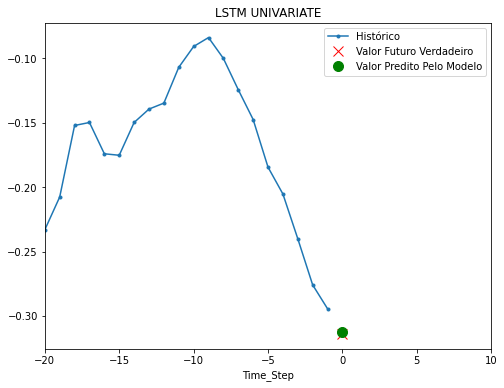

In [50]:
for i , j in val_uni.take(5):
  plot = plot_time_series([i[0].numpy() , j[0].numpy() , lstm_model.predict(i)[0]] ,0 , 'LSTM UNIVARIATE')
  plot.show()

In [51]:
lstm_model.save('lstm_model.h5') 

# gera binario do modelo keras

In [52]:
MODEL_TFLITE = '/content/lstm_model.h5'
MODEL_TFLITE_MICRO = '/content/binarioh5.cc'

In [53]:
#gerar modelo para microcontrolador

# Instale xxd se não estiver disponível
!apt-get update && apt-get -qq install xxd
# Converter para um arquivo de origem C, ou seja, um modelo TensorFlow Lite for Microcontrollers
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Atualizar nomes de variáveis
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64

In [54]:
# Imprima o arquivo de origem C
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x89, 0x48, 0x44, 0x46, 0x0d, 0x0a, 0x1a, 0x0a, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x08, 0x08, 0x00, 0x04, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0xff, 0xff, 0xff, 0xff,
  0xff, 0xff, 0xff, 0xff, 0x78, 0xa6, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,
  0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x60, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x88, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0xa8, 0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x07, 0x00, 0x01, 0x00, 0x00, 0x00, 0x18, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x10, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00,
  0x20, 0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x68, 0x01, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x54, 0x52, 0x45, 0x45, 0x00, 0x00, 0x01, 0x00,
  0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff,
  0xff, 0x

In [55]:
#converter para TensorflowLite
converter = tf.lite.TFLiteConverter.from_keras_model(lstm_model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

with open('modeltflite.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp77_3zvop/assets


INFO:tensorflow:Assets written to: /tmp/tmp77_3zvop/assets


In [56]:
MODEL_TFLITE = '/content/modeltflite.tflite'
MODEL_TFLITE_MICRO = '/content/binariotflite.cc'

In [57]:
#gerar modelo para microcontrolador

# Instale xxd se não estiver disponível
!apt-get update && apt-get -qq install xxd
# Converter para um arquivo de origem C, ou seja, um modelo TensorFlow Lite for Microcontrollers
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Atualizar nomes de variáveis
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:9 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64

In [58]:
# Imprima o arquivo de origem C
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x00, 0x00, 0x60, 0x00, 0x00, 0x00, 0x64, 0x02, 0x00, 0x00,
  0x68, 0x00, 0x00, 0x00, 0x14, 0x02, 0x00, 0x00, 0x8c, 0x01, 0x00, 0x00,
  0x12, 0x00, 0x00, 0x00, 0x90, 0x2e, 0x00, 0x00, 0xe4, 0x2d, 0x00, 0x00,
  0x28, 0x2d, 0x00, 0x00, 0x7c, 0x2c, 0x00, 0x00, 0xec, 0x2b, 0x00, 0x00,
  0x00, 0x2b, 0x00, 0x00, 0xd4, 0x29, 0x00, 0x00, 0x68, 0x28, 0x00, 0x00,
  0x0c, 0x27, 0x00, 0x00, 0xdc, 0x25, 0x00, 0x00, 0xf8, 0x22, 0x00, 0x00,
  0x64, 0x0d, 0x00, 0x00, 0xc4, 0x0b, 0x00, 0x00, 0x00, 0x09, 0x00, 0x00,
  0x64, 0x08, 0x00, 0x00, 0x84, 0x07, 0x00, 0x00, 0x94, 0x06, 0x00, 0x00,
  0xdc, 0x03, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x98, 0x24, 0x00, 0x00,
  0x34, 0x22, 0x00, 0x00, 0x10, 0x02, 0x00, 0x00, 0x4a, 0x00, 0x00, 0x00,
  0x60, 0x

In [59]:
lstm_model.save('modelTF.tf')

INFO:tensorflow:Assets written to: modelTF.tf/assets


INFO:tensorflow:Assets written to: modelTF.tf/assets


In [60]:
MODEL_TFLITE = '/content/modelTF.tf/saved_model.pb'
MODEL_TFLITE_MICRO = '/content/binariotf.cc'

In [61]:
#gerar modelo para microcontrolador

# Instale xxd se não estiver disponível
!apt-get update && apt-get -qq install xxd
# Converter para um arquivo de origem C, ou seja, um modelo TensorFlow Lite for Microcontrollers
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Atualizar nomes de variáveis
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64

In [62]:
# Imprima o arquivo de origem C
!cat {MODEL_TFLITE_MICRO}

A saída de streaming foi truncada nas últimas 5000 linhas.
  0x0a, 0x21, 0x67, 0x72, 0x61, 0x64, 0x69, 0x65, 0x6e, 0x74, 0x73, 0x2f,
  0x52, 0x65, 0x73, 0x68, 0x61, 0x70, 0x65, 0x5f, 0x31, 0x32, 0x5f, 0x67,
  0x72, 0x61, 0x64, 0x2f, 0x52, 0x65, 0x73, 0x68, 0x61, 0x70, 0x65, 0x12,
  0x07, 0x52, 0x65, 0x73, 0x68, 0x61, 0x70, 0x65, 0x1a, 0x29, 0x67, 0x72,
  0x61, 0x64, 0x69, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x63, 0x6f, 0x6e, 0x63,
  0x61, 0x74, 0x5f, 0x31, 0x5f, 0x67, 0x72, 0x61, 0x64, 0x2f, 0x53, 0x6c,
  0x69, 0x63, 0x65, 0x5f, 0x31, 0x32, 0x3a, 0x6f, 0x75, 0x74, 0x70, 0x75,
  0x74, 0x3a, 0x30, 0x1a, 0x28, 0x67, 0x72, 0x61, 0x64, 0x69, 0x65, 0x6e,
  0x74, 0x73, 0x2f, 0x52, 0x65, 0x73, 0x68, 0x61, 0x70, 0x65, 0x5f, 0x31,
  0x32, 0x5f, 0x67, 0x72, 0x61, 0x64, 0x2f, 0x53, 0x68, 0x61, 0x70, 0x65,
  0x3a, 0x6f, 0x75, 0x74, 0x70, 0x75, 0x74, 0x3a, 0x30, 0x2a, 0x07, 0x0a,
  0x01, 0x54, 0x12, 0x02, 0x30, 0x01, 0x2a, 0x1a, 0x0a, 0x0e, 0x5f, 0x6f,
  0x75, 0x74, 0x70, 0x75, 0x74, 0x5f, 0x73, 0x68, 0x6

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0x69, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x52, 0x65, 0x73, 0x68,
  0x61, 0x70, 0x65, 0x5f, 0x38, 0x5f, 0x67, 0x72, 0x61, 0x64, 0x2f, 0x53,
  0x68, 0x61, 0x70, 0x65, 0x3a, 0x6f, 0x75, 0x74, 0x70, 0x75, 0x74, 0x3a,
  0x30, 0x2a, 0x07, 0x0a, 0x01, 0x54, 0x12, 0x02, 0x30, 0x01, 0x2a, 0x1a,
  0x0a, 0x0e, 0x5f, 0x6f, 0x75, 0x74, 0x70, 0x75, 0x74, 0x5f, 0x73, 0x68,
  0x61, 0x70, 0x65, 0x73, 0x12, 0x08, 0x0a, 0x06, 0x3a, 0x04, 0x12, 0x02,
  0x08, 0x10, 0x1a, 0x68, 0x0a, 0x1e, 0x67, 0x72, 0x61, 0x64, 0x69, 0x65,
  0x6e, 0x74, 0x73, 0x2f, 0x52, 0x65, 0x73, 0x68, 0x61, 0x70, 0x65, 0x5f,
  0x39, 0x5f, 0x67, 0x72, 0x61, 0x64, 0x2f, 0x53, 0x68, 0x61, 0x70, 0x65,
  0x12, 0x05, 0x43, 0x6f, 0x6e, 0x73, 0x74, 0x2a, 0x1a, 0x0a, 0x0e, 0x5f,
  0x6f, 0x75, 0x74, 0x70, 0x75, 0x74, 0x5f, 0x73, 0x68, 0x61, 0x70, 0x65,
  0x73, 0x12, 0x08, 0x0a, 0x06, 0x3a, 0x04, 0x12, 0x02, 0x08, 0x01, 0x2a,
  0x0b, 0x0a, 0x05, 0x64, 0x74, 0x79, 0x70, 0x65, 0x12, 0x02, 0x30, 0x03,
  0x2a, 0x16, 0x0a, 0x05, 0x76, 0x61, 0x6c, 0x75, 0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

